# GEONE - DEESSE - Advanced use of pyramids

## Main points addressed

- computing pyramid of images: 'reduce' and 'expand' operations
- deesse simulation using pyramids:
    - retrieving simulation from pyramid levels
    - setting hard data directly into pyramid levels

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


## 1. Gaussian reduction and expansion
Gaussian transformation (reduction or expansion) consists in applying a weighted moving average on an image, using a Gaussian-like kernel (or filter) while reducing or expanding the number of cells along each direction:

- reduction allows to get a representation of an image with a lower resolution;
- expansion allows to get an image with a higher resolution.

Applying a Gaussian reduction to an initial image, and then a Gaussian expansion from the reduced image results in an approximation of the initial image (some information has been lost). 

A Gaussian pyramid can be built by repeating Gaussian reduction and expansion operations. Deesse uses this concept (if pyramid is enabled) to generate multi-resolution simulations, which can help to better reproduce the spatial structures.

**Note:** as the Gaussian operation consists in a weighted moving average, it makes sense only for *continuous* variables. If a categorical variable is considered, such operation should be applied to the indicator variables of the categories, or the variable should first be "transformed" into a continuous variable.

## 1.1 Gaussian pyramid - continuous image

### Initial image 
Source of the image: *T. Zhang, P. Switzer, and A. Journel, Filter-based classification of training image patterns for spatial simulation, MATHEMATICAL GEOLOGY, 38(1):63-80, JAN 2006,[ doi:10.1007/s11004-005-9004-x](https://dx.doi.org/10.1007/s11004-005-9004-x).*

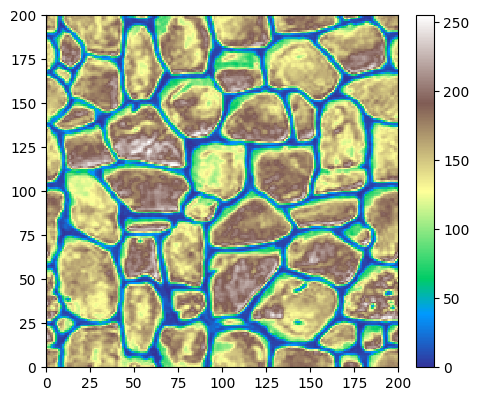

In [3]:
# Read file 
data_dir = 'data'
filename = os.path.join(data_dir, 'tiContinuous.txt')
im = gn.img.readImageTxt(filename)

# Color settings
cmap='terrain'
vmin, vmax = im.vmin(), im.vmax()

# Plot
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(im, cmap=cmap, vmin=vmin, vmax=vmax)
plt.show()

Set some missing value (`nan`) to see the impact on further transformations.

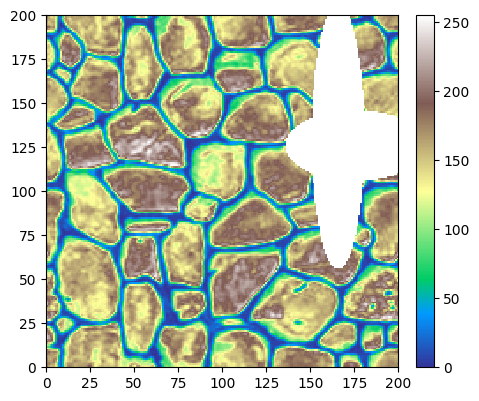

In [4]:
# coordinates of centre of every cell
im_yy, im_xx = im.yy()[0], im.xx()[0]
#im_yy, im_xx = np.meshgrid(im.y(), im.x(), indexing='ij') # equiv.

# Set nan value to cells with a distance to a given point (anisotropic distance) less than a given value
xc, yc = 175.5, 125.5
xs, ys = 1.0, 0.5
d = 40.0

im.val[0,0][((im_xx - xc)/xs)**2 + ((im_yy - yc)/ys)**2 < d**2] = np.nan

# Again...
xc, yc = 165.5, 130.5
xs, ys = 0.2, 1.0
d = 75.0

im.val[0,0][((im_xx - xc)/xs)**2 + ((im_yy - yc)/ys)**2 < d**2] = np.nan

# Plot resulting image
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(im, cmap='terrain')
plt.show()

### Apply reduction and expansion - function `geone.deesseinterface.imgPyramidImage`

This function applies the desired transformation (reduction or expansion) to all variables of the input image (given in first argument). 

The operation is specified by the keyword argument `operation` with value (string) 'reduce' (default) or 'expand'. 

The reduction / expansion factors along each axis direction are given by the keyword arguments `kx`, `ky`, `kz`: the weighted moving average will be done using a Gaussian-like kernel (or filter) of size `2*kx + 1` $\times$ `2*ky + 1` $\times$ `2*kz + 1`, while dividing, if `operation='reduce'` (resp. multiplying, if `operation='expand'`), the number of cells along the axis x, y, z by a factor (of about) `kx`, `ky`, `kz` respectively. Setting a factor to 0 means no reduction/expansion in the corresponding direction. By default (`None`), each factor is set to 2, provided that the number of cells in the corresponding direction is greater than 1 (otherwise the factor is set to 0).

The minimal weight on informed cells within the kernel to define an output value can be specified by the keyword argument `minWeight`: if the total weight on informed cells within the kernel is less than this value, undefined value (`nan`) is set as output value. Specifiying `None` (default) or a negative value implies that a default minimal weight will be used.

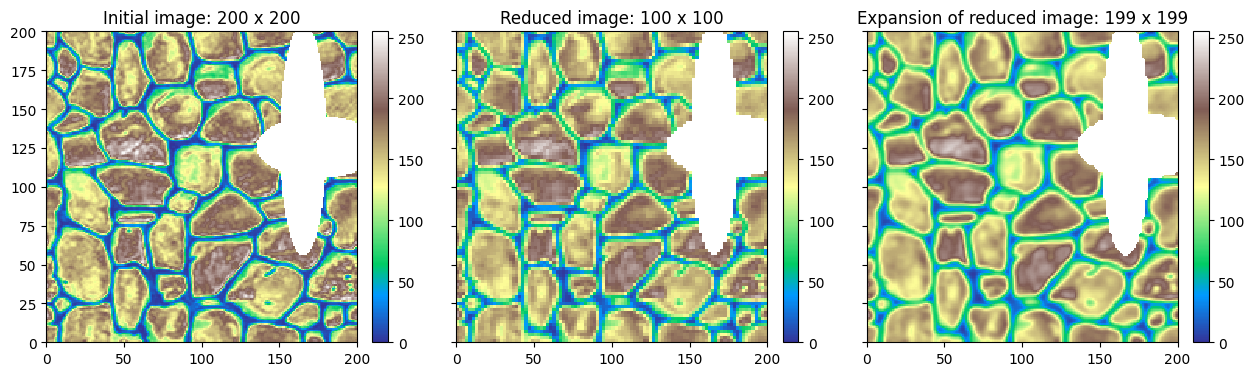

In [5]:
# Reduce image
im_red = gn.deesseinterface.imgPyramidImage(im, operation='reduce')

# Expand the reduced image
im_red_exp = gn.deesseinterface.imgPyramidImage(im_red, operation='expand')

# Plot
plt.subplots(1,3, sharey=True, figsize=(15,5))

plt.subplot(1,3,1)
gn.imgplot.drawImage2D(im, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title(f'Initial image: {im.nx} x {im.ny}')

plt.subplot(1,3,2)
gn.imgplot.drawImage2D(im_red, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title(f'Reduced image: {im_red.nx} x {im_red.ny}')

plt.subplot(1,3,3)
gn.imgplot.drawImage2D(im_red_exp, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title(f'Expansion of reduced image: {im_red_exp.nx} x {im_red_exp.ny}')

plt.show()

### Gaussian pyramid
Build a Gaussian pyramid by repeating the above operations.

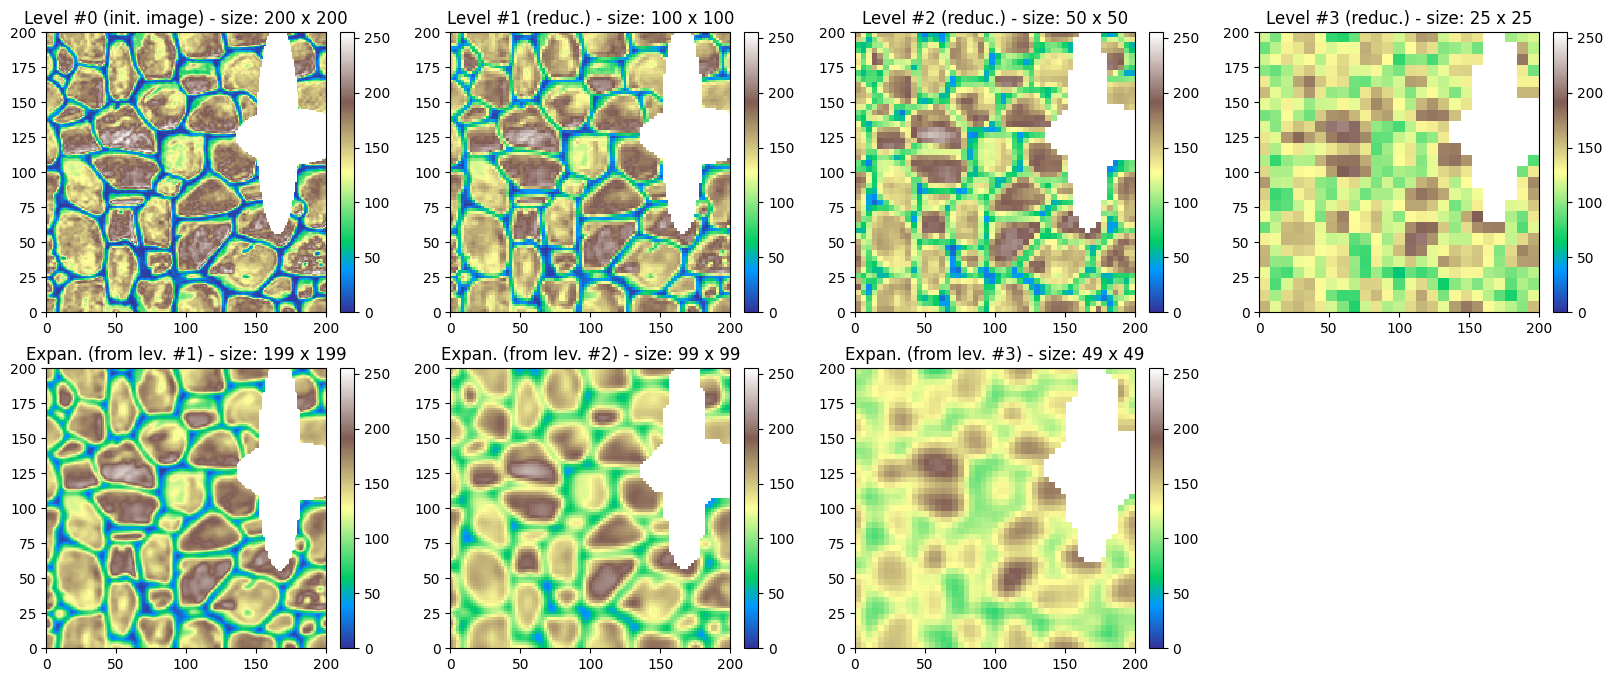

In [6]:
nlevel = 3

# Reduce successively
im_list = [im]
for i in range(nlevel):
    im_list.append(gn.deesseinterface.imgPyramidImage(im_list[-1], operation='reduce'))

# Expand
im2_list = [gn.deesseinterface.imgPyramidImage(imj, operation='expand') for imj in im_list[1:]]

# Plot
plt.subplots(2, nlevel+1, figsize=(20,8))

for i, imj in enumerate(im_list):
    plt.subplot(2, nlevel+1, i+1)
    gn.imgplot.drawImage2D(imj, cmap=cmap, vmin=vmin, vmax=vmax)
    if i==0:
        plt.title(f'Level #{i} (init. image) - size: {imj.nx} x {imj.ny}')
    else:
        plt.title(f'Level #{i} (reduc.) - size: {imj.nx} x {imj.ny}')

for i, imj in enumerate(im2_list):
    plt.subplot(2, nlevel+1, nlevel+1+i+1)
    gn.imgplot.drawImage2D(imj, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(f'Expan. (from lev. #{i+1}) - size: {imj.nx} x {imj.ny}')

plt.subplot(2, nlevel+1, 2*(nlevel+1))
plt.axis('off')

plt.show()

## 1.2 Gaussian pyramid - categorical image

In order that Gaussian reduction / expansion makes sense, it should be applied onto continuous variables. To deal with a categorical image, the idea is:

- to consider the indicator variables of the categories, taken values 0 and 1 and treated as continuous,
- or to transform the categorical variable into a continuous variable; this can be done while accounting for the connection (contact between) the categories (see further).

### Initial image 

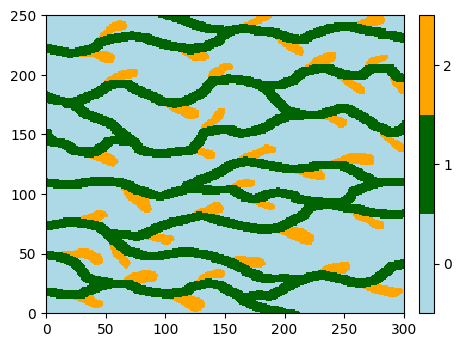

In [7]:
# Read file 
data_dir = 'data'
filename = os.path.join(data_dir, 'ti.txt')
im = gn.img.readImageTxt(filename)

# Setting for categories / colors
categ_val = [0, 1, 2]
categ_col = ['lightblue', 'darkgreen', 'orange']

plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(im, categ=True, categVal=categ_val, categCol=categ_col)
plt.show()

Set some missing value (`nan`) to see the impact on further transformations.

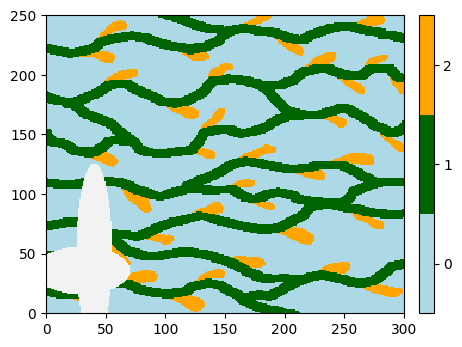

In [8]:
# coordinates of centre of every cell
im_yy, im_xx = im.yy()[0], im.xx()[0]
#im_yy, im_xx = np.meshgrid(im.y(), im.x(), indexing='ij') # equiv.

# Set nan value to cells with a distance to a given point (anisotropic distance) less than a given value
xc, yc = 30.5, 35.5
xs, ys = 1.0, 0.5
d = 40.0

im.val[0,0][((im_xx - xc)/xs)**2 + ((im_yy - yc)/ys)**2 < d**2] = np.nan

# Again...
xc, yc = 40.5, 50.5
xs, ys = 0.2, 1.0
d = 75.0

im.val[0,0][((im_xx - xc)/xs)**2 + ((im_yy - yc)/ys)**2 < d**2] = np.nan

# Plot resulting image
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(im, categ=True, categVal=categ_val, categCol=categ_col)
plt.show()

### Set image of indicator variables

Define the image with as many variables as number of categories, one indicator variable per category. These variables take the value 0 and 1, and can be treated as continuous variables: they are interpreted as proportions of the corresponding category.

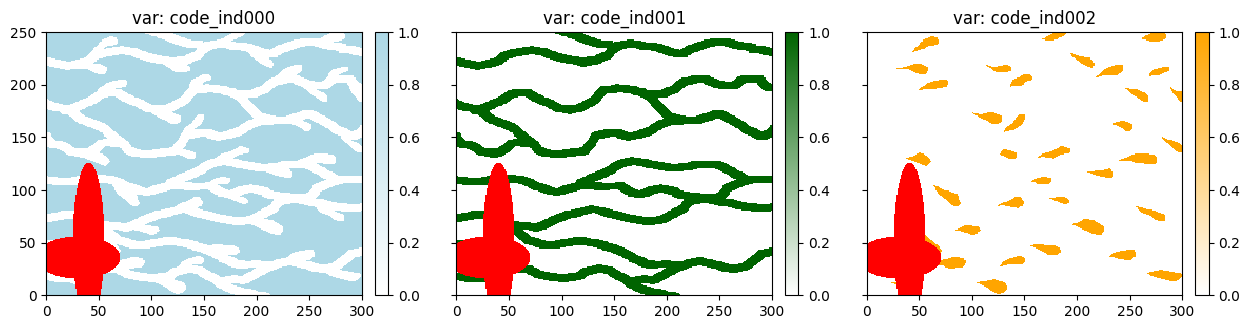

In [9]:
# Get list of category value 
categ = im.get_unique()

# Compute image of indicator variables
im_indicator = gn.img.indicatorImage(im, categ=categ)

# Define color map for each indicator
cmap = [gn.customcolors.custom_cmap(['white', c], cbad='red') for c in categ_col] # missing value (nan) in red

# Plot
plt.subplots(1, im_indicator.nv, sharey=True, figsize=(15,5))

for i in range(im_indicator.nv):
    plt.subplot(1, im_indicator.nv, i+1)
    gn.imgplot.drawImage2D(im_indicator, iv=i, cmap=cmap[i], vmin=0, vmax=1)
    plt.title(f'var: {im_indicator.varname[i]}')

plt.show()

### Gaussian pyramid
Build a Gaussian pyramid for every indicator variable.

In [10]:
nlevel = 2

# Reduce successively
im_list = [im_indicator]
for i in range(nlevel):
    im_list.append(gn.deesseinterface.imgPyramidImage(im_list[-1], operation='reduce'))

# Expand
im2_list = [gn.deesseinterface.imgPyramidImage(imj, operation='expand') for imj in im_list[1:]]

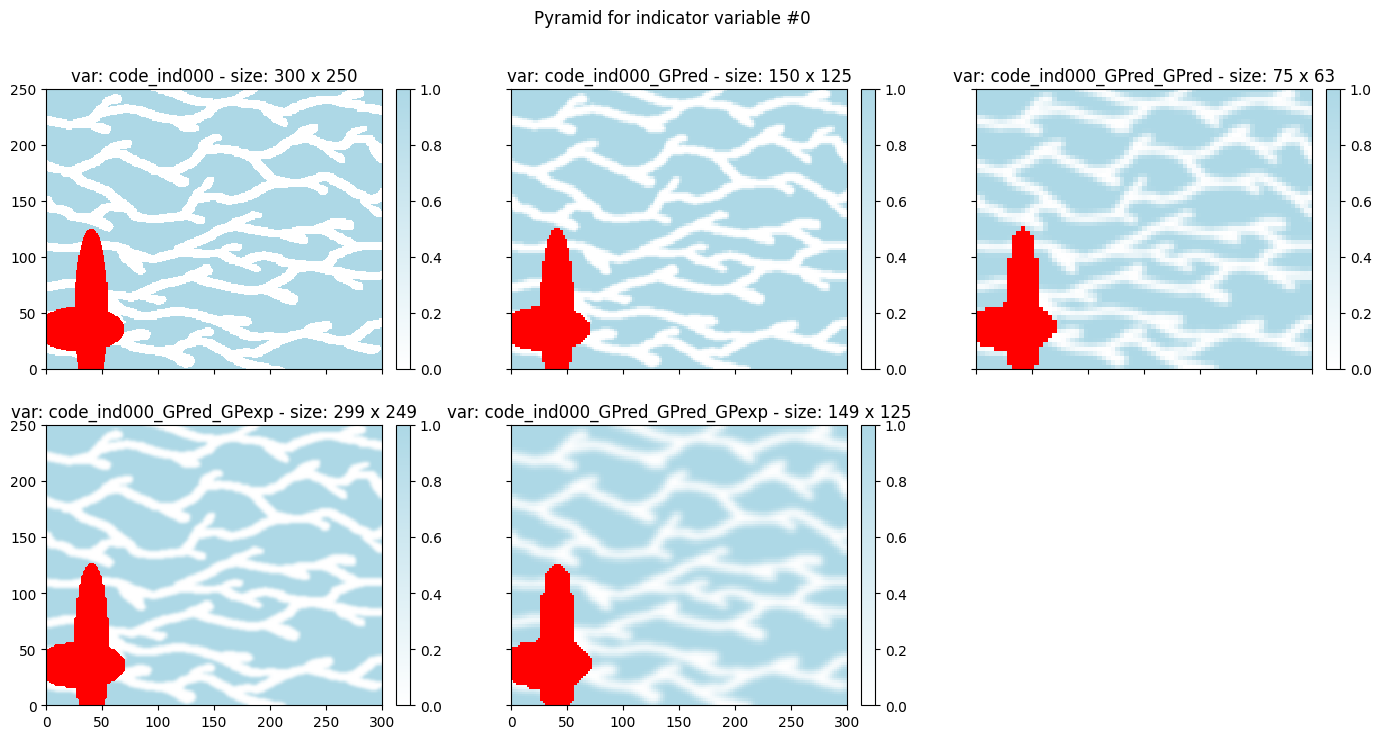

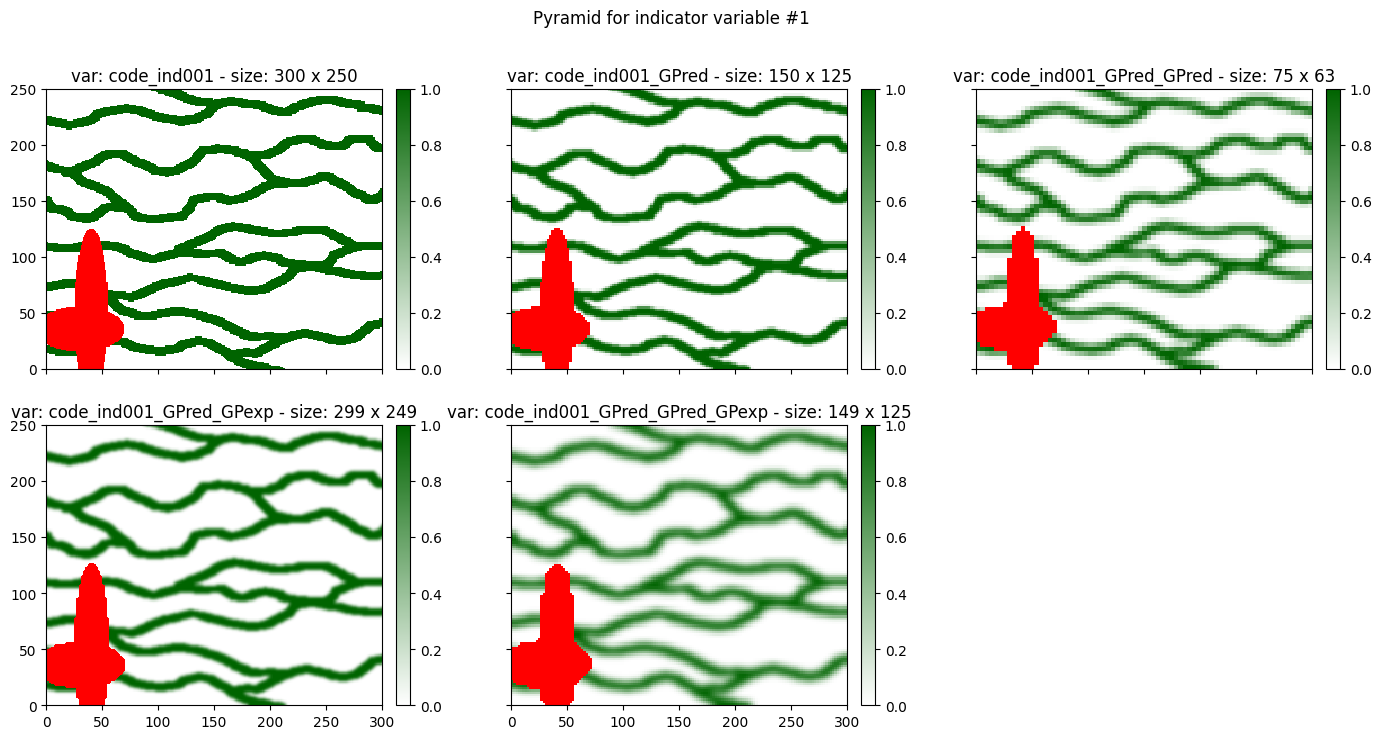

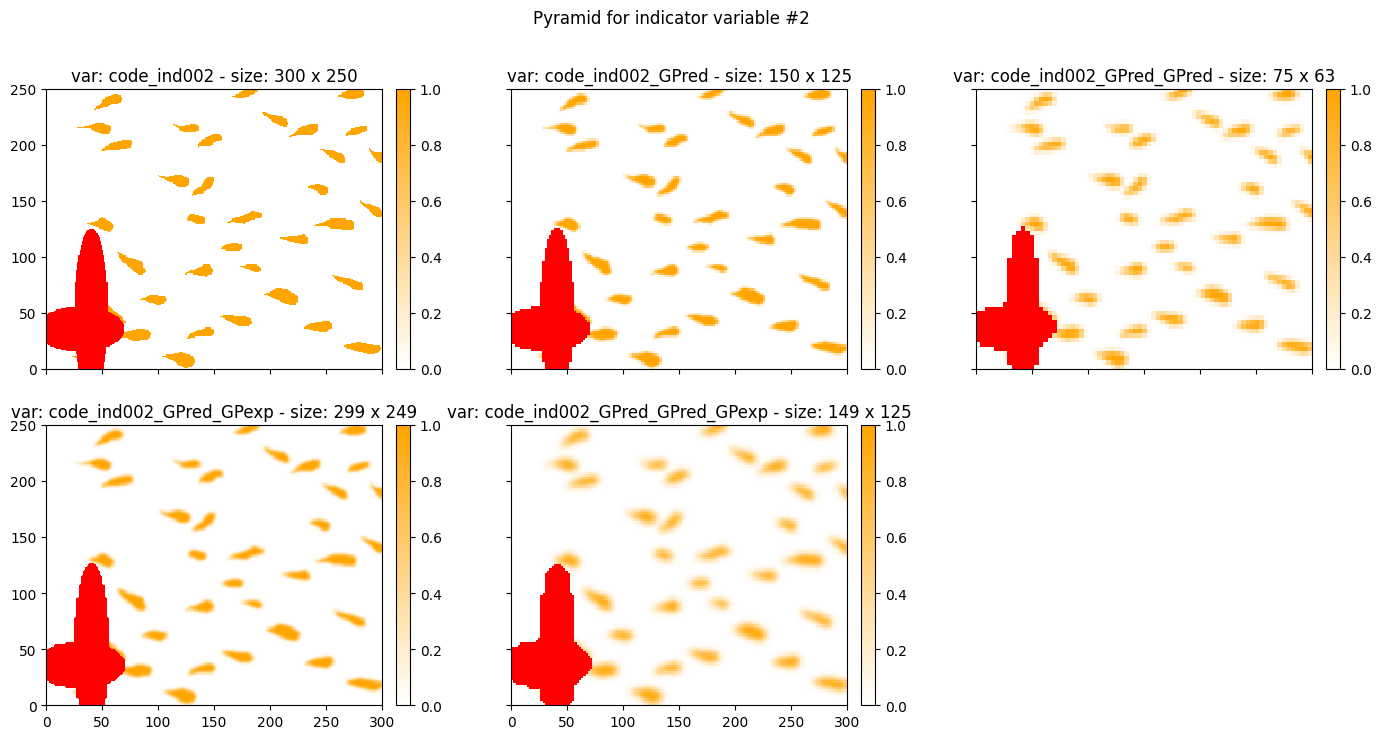

In [11]:
for iv in range(im_indicator.nv):
    # Plot - indicator "iv"
    plt.subplots(2, nlevel+1, figsize=(17,8), sharex=True, sharey=True)

    for i, imj in enumerate(im_list):
        plt.subplot(2, nlevel+1, i+1)
        gn.imgplot.drawImage2D(imj, iv=iv, cmap=cmap[iv], vmin=0, vmax=1)
        plt.title(f'var: {imj.varname[iv]} - size: {imj.nx} x {imj.ny}')

    for i, imj in enumerate(im2_list):
        plt.subplot(2, nlevel+1, nlevel+1+i+1)
        gn.imgplot.drawImage2D(imj, iv=iv, cmap=cmap[iv], vmin=0, vmax=1)
        plt.title(f'var: {imj.varname[iv]} - size: {imj.nx} x {imj.ny}')

    plt.subplot(2, nlevel+1, 2*(nlevel+1))
    plt.axis('off')

    plt.suptitle(f'Pyramid for indicator variable #{iv}')

plt.show()

### Transform categorical variable into continous variable

The function `geone.deesseinterface.imgCategoricalToContinuous` allows to transform a categorical variable into a "continuous" variable (with values in $[0, 1]$), while accounting for the connections (contacts) between the categories. For a variable with $n$ categories:

- each category will correspond to a distinct output value in $\{i/(n-1), i=0, ..., n-1\}$
- the output values are set such that "closer values correspond to better connected (more contact btw.) corresponding categories"
- this is the transformation done by deesse when pyramid is used with pyramid type set to 'categorical_to_continuous'

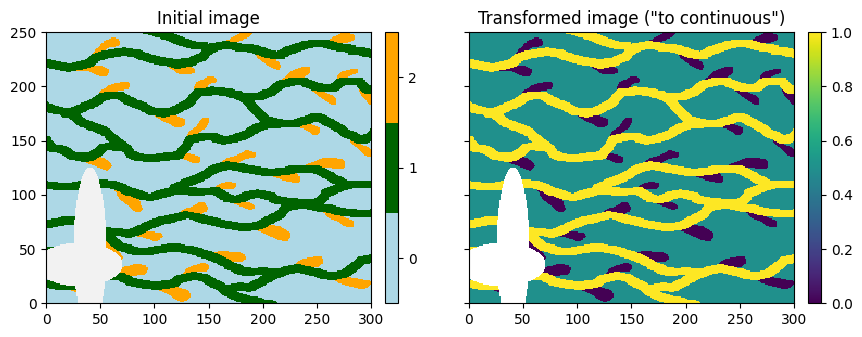

In [12]:
# Compute new image with transformed variable
im_toContinuous = gn.deesseinterface.imgCategoricalToContinuous(im)

# Color map for "continuous" image
cmap_cont = 'viridis'

# Plot
plt.subplots(1,2, sharey=True, figsize=(10,5))

# Initial image 
plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im, categ=True, categVal=categ_val, categCol=categ_col)
plt.title('Initial image')

# Transformed image 
plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im_toContinuous, cmap=cmap_cont, vmin=0, vmax=1)
plt.title('Transformed image ("to continuous")')

plt.show()

Note that the background category in initial image (code 0) becomes the middle value in the transformed image.

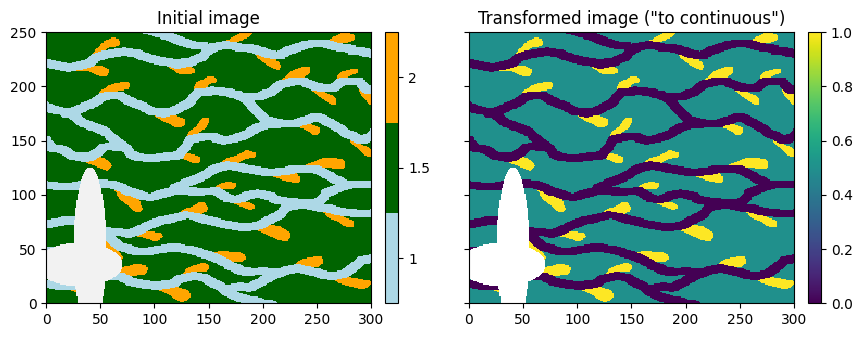

In [13]:
# Test with same initial image, but changing the category codes
im_tmp = gn.img.copyImg(im)
im_tmp.val[im_tmp.val==0] = 1.5

# Compute new image with transformed variable
im_tmp_toContinuous = gn.deesseinterface.imgCategoricalToContinuous(im_tmp)

# Plot
plt.subplots(1,2, sharey=True, figsize=(10,5))

# Initial image 
plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im_tmp, categ=True, categCol=categ_col)
plt.title('Initial image')

# Transformed image 
plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im_tmp_toContinuous, cmap=cmap_cont, vmin=0, vmax=1)
plt.title('Transformed image ("to continuous")')

plt.show()

Note that the background category in initial image still becomes the middle value in the transformed image. Note also that the output values are regularly spaced in the interval $[0, 1]$.

### Gaussian pyramid
Build a Gaussian pyramid of the transformed image.

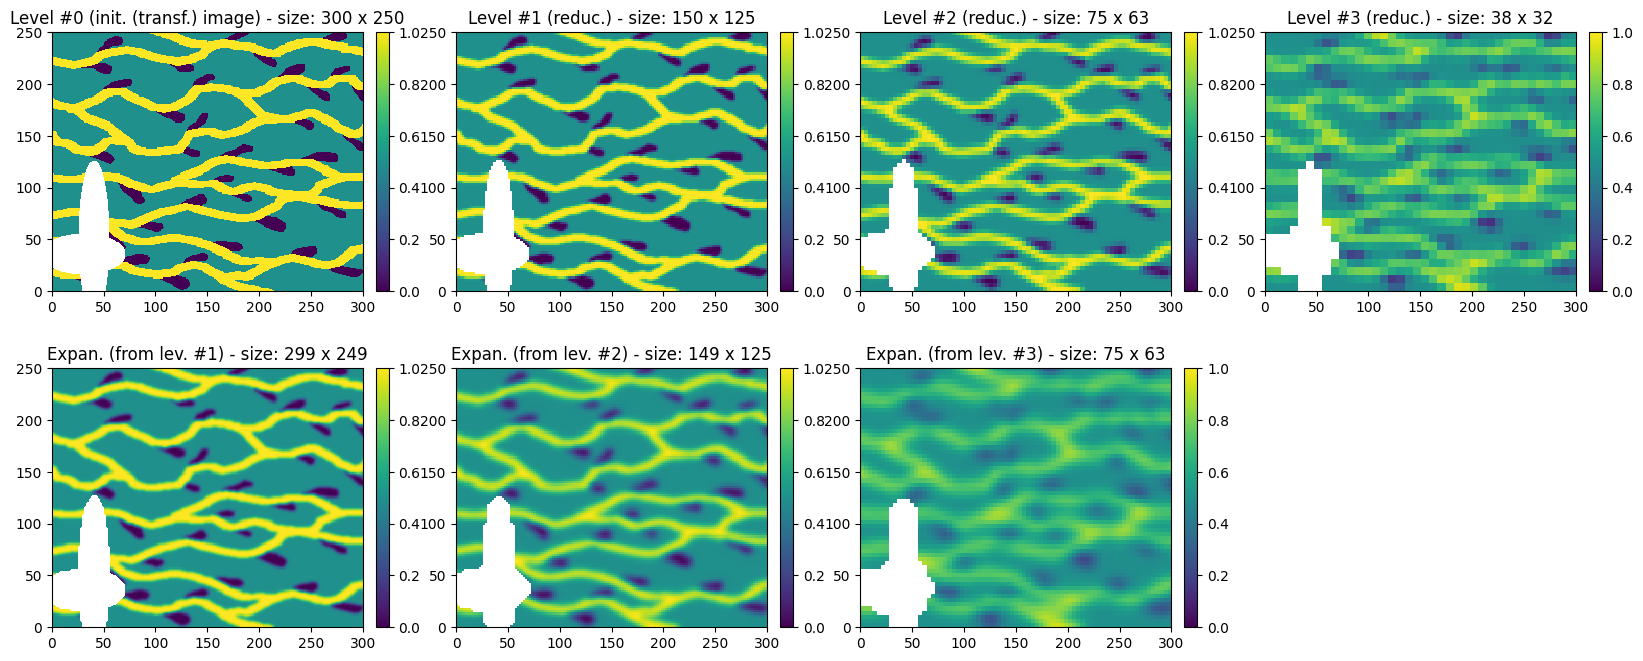

In [14]:
nlevel = 3

# Reduce successively
im_list = [im_toContinuous]
for i in range(nlevel):
    im_list.append(gn.deesseinterface.imgPyramidImage(im_list[-1], operation='reduce'))

# Expand
im2_list = [gn.deesseinterface.imgPyramidImage(imj, operation='expand') for imj in im_list[1:]]

# Plot
plt.subplots(2, nlevel+1, figsize=(20,8))

for i, imj in enumerate(im_list):
    plt.subplot(2, nlevel+1, i+1)
    gn.imgplot.drawImage2D(imj, cmap=cmap_cont, vmin=0, vmax=1)
    if i==0:
        plt.title(f'Level #{i} (init. (transf.) image) - size: {imj.nx} x {imj.ny}')
    else:
        plt.title(f'Level #{i} (reduc.) - size: {imj.nx} x {imj.ny}')

for i, imj in enumerate(im2_list):
    plt.subplot(2, nlevel+1, nlevel+1+i+1)
    gn.imgplot.drawImage2D(imj, cmap=cmap_cont, vmin=0, vmax=1)
    plt.title(f'Expan. (from lev. #{i+1}) - size: {imj.nx} x {imj.ny}')

plt.subplot(2, nlevel+1, 2*(nlevel+1))
plt.axis('off')

plt.show()

## 2. Deesse simulations with pyramids

When enabling pyramids in deesse simulation set-up, it can help to better reproduce the spatial structures (see jupyter notebook `ex_deesse_01_basics.ipynb` for basic examples). 

The principle of simulation with $n$ pyramid levels (in addition to the initial grid), indexed from 0 (initial grid) to $n$ (coarsest resolution) is the following.

### Unconditional simulations

1. build a pyramid of the training image
2. build the simulation grid (support) for every pyramid level
3. do a deesse simulation at the coarsest resolution (level index $n$)
4. for $j = n-1, \ldots, 0$, repeat:
    - expand the simulation result from level $j+1$ to level $j$
    - do multi-variate deesse simulation at level $j$, conditioned to the expanded simulation

Note that, for a given level, the same grid is used (same support) for all variables, expanded and reduced. In the illustrations above, the dimensions of the grid can differ a little in a given level; in such a situation, the expanded image is enlarged by adding missing value in order to have the same grid (support).

### Conditional simulations

#### Usual conditioning data
Usual conditioning data, i.e. conditioning data given in the initial grid, are handled as follows. As the simulation starts at the coarsest level, information derived from the conditioning data has to be propagated through the pyramid (into the sequence of reduced images) up to the coarsest level. This is done after the step 2. and before the step 3. above, by applying successive Gaussian reductions to spread "dense" conditioning data and by doing successive "local" deesse simulations conditioned to the previous pyramid level (simulation with two different supports !); these additional steps are managed by deesse.

#### Conditioning data in additional pyramid levels
Moreover, conditioning data can be directly given in any pyramid level. Such conditioning data are simply integrated into the pyramid. 

Note the following to deal with conditioning data within the (additional) pyramid levels (level from index $1$):

- the variables are identified by their name: the name should be set to `<vname>_ind<j>_lev<k>`, where `<vname>` is the name of the "original" variable, `<j>` is the pyramid index for that variable, and `<k>` is the level index in $\{1, \ldots, n\}$, with `<j>` and `<k>` written on 3 digits with leading zeros
- the conditioning data values are the (already) normalized values (as used during the simulation in every level);
- the grid dimensions (support) of the level in which the data are given are used: for data images the grid must be compatible, and for data point sets the locations (coordinates) must be given accordingly
- conditioning data integrated in pyramid may erased (replaced) data already set or computed from conditioning data at the level one rank finer

**Remark:** the variable (name) are indexed (index starting at 0) in any pyramid level. If the original variable (i.e. in the initial grid) is:

- *a continuous variable, or a categorical variable and the pyramid type is set to categorical_to_continuous':* only one variable will be computed / simulated in each pyramid level (without taking into account the expanded part of the pyramid), hence the unique index will be 0 (suffix '_ind000') used after the original variable name
- *a categorical variable and the pyramid type is set to categorical_auto':* a pyramid will be computed / simulated for the indicator variables of all categories except one; then, for a $m$-category variables, the indexes $0, \ldots, m-2$ will be used  with corresponding suffixes

### Retrieving simulations from pyramid levels
When pyramids are used for deesse simulation, the simulation results within the pyramid levels can be retrieved in output (normalized variables are retrieved). This is specified by the field `outputLevelFlag` of the class `geone.deesseinterface.PyramidParameters` (required in input for each variable).

The simulation results in the pyramid (additional levels) are stored under the key `'sim_pyramid'` in the dictionnary returned by the deesse simulation. This field consists in a list `sim_pyramid` of length $n$, the number of (additional) pyramid levels, with:

- `sim_pyramid[j]`: a one dimensional array of images containing the results from pyramid level of index `j+1`
- `sim_pyramid[j][i]`: the `i`-th realization in pyramid level of index `j+1` (excluding expanded variables)

Note that `sim_pyramid` is `None` if no output in any level is specified in the deesse set-up. As soon as some information is stored in output for any of the $n$ levels, `sim_pyramid` is a list of length $n$, with possibly some element set to `None`: `sim_pyramid[j]` will be `None` if there is no output in the level of index `j+1`.

### 2.1 Deesse simulations with pyramids - continuous variable

#### Unconditional simulation

In [15]:
# Set-up for deesse
# -----------------
# Training image: one continuous variable 
ti = gn.img.readImageTxt(os.path.join(data_dir, 'tiContinuous.txt'))

# Pyramid parameters
# ... general
pyrGenParams = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=2,                 # number of pyramid levels, additional to the simulation grid
    kx=[2, 2], ky=[2, 2], kz=[0, 0]  # reduction factors from one level to the next one
                                     #    (kz=[0, 0]: do not apply reduction along z axis)
)
# ... for the variable
pyrParams = gn.deesseinterface.PyramidParameters(
    nlevel=2,                     # number of levels
    pyramidType='continuous',     # type of pyramid
    outputLevelFlag=[True, True]  # specifying for each level if the simulation is retrieved (True) 
                                  #     in output or not (False); outputLevelFlag[j] refers to level of
                                  #     index j+1
)

# number of realizations
nreal = 4

# deesse input
deesse_input = gn.deesseinterface.DeesseInput(
    nx=220, ny=180, nz=1,
    nv=1, varname='var',
    TI=ti,
    distanceType='continuous',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams, # set pyramid general parameters
    pyramidParameters=pyrParams,           # set pyramid parameters for each variable
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
# ----------
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun_mp(deesse_input, nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun_mp: DeeSse running on 4 process(es)... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
deesseRun_mp: DeeSse run complete (all process(es))
Elapsed time: 1.9 sec


In [16]:
# Retrieve the realizations 
# ... in initial grid
sim = deesse_output['sim']

# ... in (additional) pyramid levels
sim_pyramid = deesse_output['sim_pyramid']

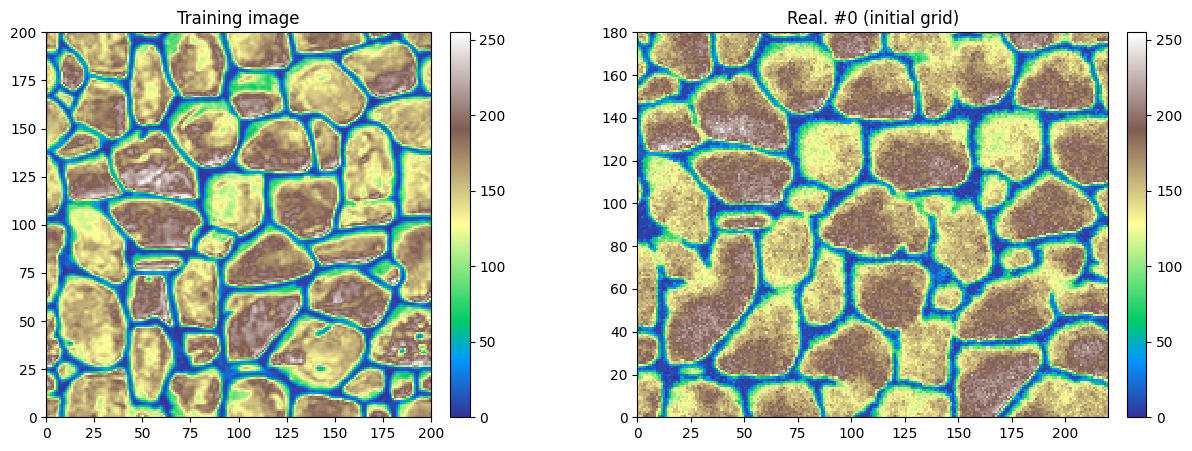

In [17]:
# Color settings
cmap = 'terrain'
vmin = ti.val[0].min()
vmax = ti.val[0].max()

# Display final result (in inital grid)
i = 0 # realization index

plt.subplots(1, 2, figsize=(15,5))


# Training image
plt.subplot(1,2,1)
gn.imgplot.drawImage2D(ti, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title('Training image')

# Simulation
plt.subplot(1,2,2)
gn.imgplot.drawImage2D(sim[i], cmap=cmap, vmin=vmin, vmax=vmax)
plt.title(f'Real. #{i} (initial grid)')

plt.show()

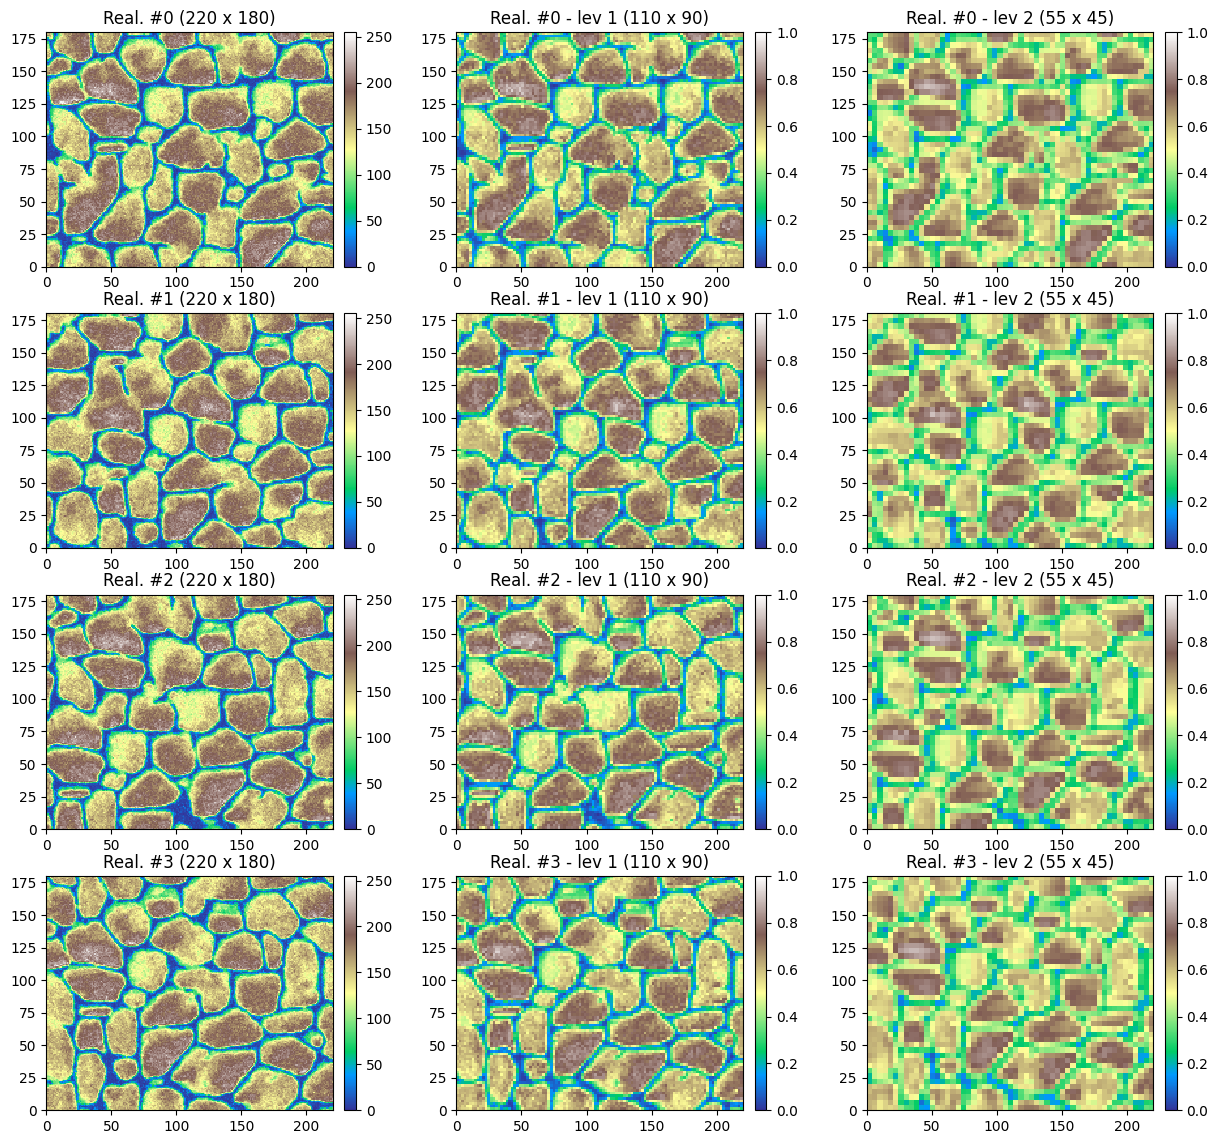

In [18]:
# Display detailed results (simulation in the pyramid), 2 first realizations
nlevel = len(sim_pyramid)

nn = 4 # number of realizations to display

plt.subplots(nn, nlevel+1, figsize=(15,nn*3.5))

for i in range(nn):
    # Realization (final, initial grid)
    plt.subplot(nn, nlevel+1, i*(nlevel+1)+1)
    gn.imgplot.drawImage2D(sim[i], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(f'Real. #{i} ({sim[i].nx} x {sim[i].ny})')

    # Realization in additional pyramid levels
    for j in range(nlevel):
        plt.subplot(nn, nlevel+1, i*(nlevel+1)+j+2)
        gn.imgplot.drawImage2D(sim_pyramid[j][i], cmap=cmap, vmin=0, vmax=1)
        plt.title(f'Real. #{i} - lev {j+1} ({sim_pyramid[j][i].nx} x {sim_pyramid[j][i].ny})')

plt.show()

Note that in the additional pyramid levels, the normalized variable is retrieved.

#### Setting conditioning data in the pyramid
The hard data for additional pyramid levels can be passed to deesse through *point sets*, i.e. class `geone.img.PointSet` (keyword argument `pyramidDataPointSet`) or through *images*, i.e. class `geone.img.Img` (keyword argument `pyramidDataImage`, as below), and can contain missing (uninformed) data (`nan`).

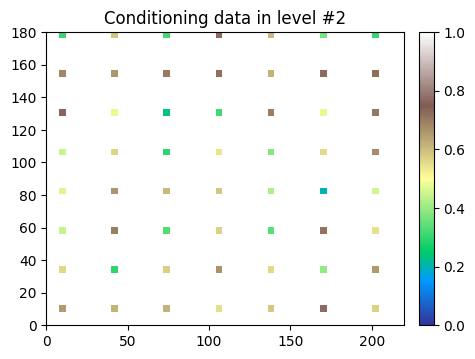

In [19]:
# Set data image for pyramid level: sample one realization in one level from the results above
# --------------------------------
ilev = 2  # level index
ireal = 0 # realization index
# Copy the image
hd_im_lev = gn.img.copyImg(sim_pyramid[ilev-1][ireal])

# Erase all values 
hd_im_lev.val[0,0,:,:] = np.nan

# Set again values: 1 over my cell along x, 1 over my cell along y
ix0, iy0 = 2, 2 # starting index
mx, my = 8, 6 # step
iy, ix = np.meshgrid(np.arange(iy0, hd_im_lev.ny, my), np.arange(ix0, hd_im_lev.nx, mx), indexing='ij')
hd_im_lev.val[0,0,iy,ix] = sim_pyramid[ilev-1][ireal].val[0,0,iy,ix]

# Plot data image
# ---------------
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(hd_im_lev, cmap=cmap, vmin=0, vmax=1)
plt.title(f'Conditioning data in level #2')
plt.show()

Note that the variable name is used to identify where the data has to be integrated. (Hence, here it must be adapted by removing the suffix '_real00000'.)

In [20]:
hd_im_lev.varname

[np.str_('var_ind000_lev002_real00000')]

In [21]:
hd_im_lev.varname = [s.replace('_real00000', '') for s in hd_im_lev.varname]
hd_im_lev.varname

['var_ind000_lev002']

In [22]:
# Set-up for deesse
# -----------------
# number of realizations
nreal = 50

# deesse input
deesse_input = gn.deesseinterface.DeesseInput(
    nx=220, ny=180, nz=1,
    nv=1, varname='var',
    TI=ti,
    distanceType='continuous',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams, # same parameters as above
    pyramidParameters=pyrParams,           # same parameters as above (outputLevelFlag could be changed)
    pyramidDataImage=hd_im_lev,            # set data image for pyramid
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
# ----------
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun_mp(deesse_input, nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun_mp: DeeSse running on 4 process(es)... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
deesseRun_mp: DeeSse run complete (all process(es))
Elapsed time: 23 sec


In [23]:
# Retrieve the realizations 
# ... in initial grid
sim = deesse_output['sim']

# ... in (additional) pyramid levels
sim_pyramid = deesse_output['sim_pyramid']

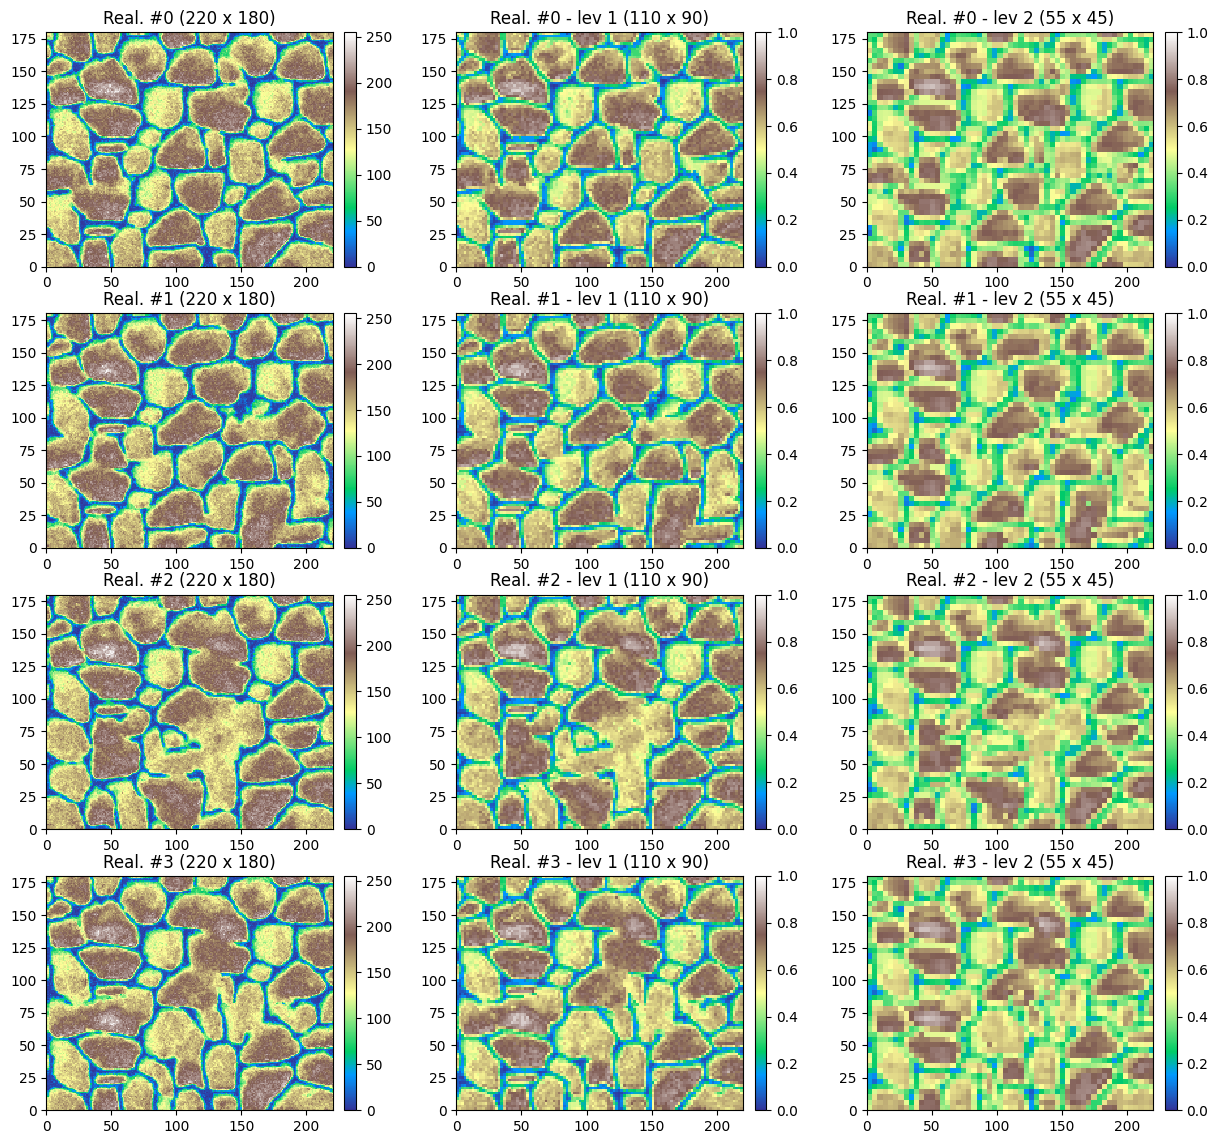

In [24]:
# Display detailed results (simulation in the pyramid), 2 first realizations
nlevel = len(sim_pyramid)

nn = 4 # number of realizations to display

plt.subplots(nn, nlevel+1, figsize=(15,nn*3.5))

for i in range(nn):
    # Realization (final, initial grid)
    plt.subplot(nn, nlevel+1, i*(nlevel+1)+1)
    gn.imgplot.drawImage2D(sim[i], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(f'Real. #{i} ({sim[i].nx} x {sim[i].ny})')

    # Realization in additional pyramid levels
    for j in range(nlevel):
        plt.subplot(nn, nlevel+1, i*(nlevel+1)+j+2)
        gn.imgplot.drawImage2D(sim_pyramid[j][i], cmap=cmap, vmin=0, vmax=1)
        plt.title(f'Real. #{i} - lev {j+1} ({sim_pyramid[j][i].nx} x {sim_pyramid[j][i].ny})')

plt.show()

#### Do some statistics over the ensemble of realizations

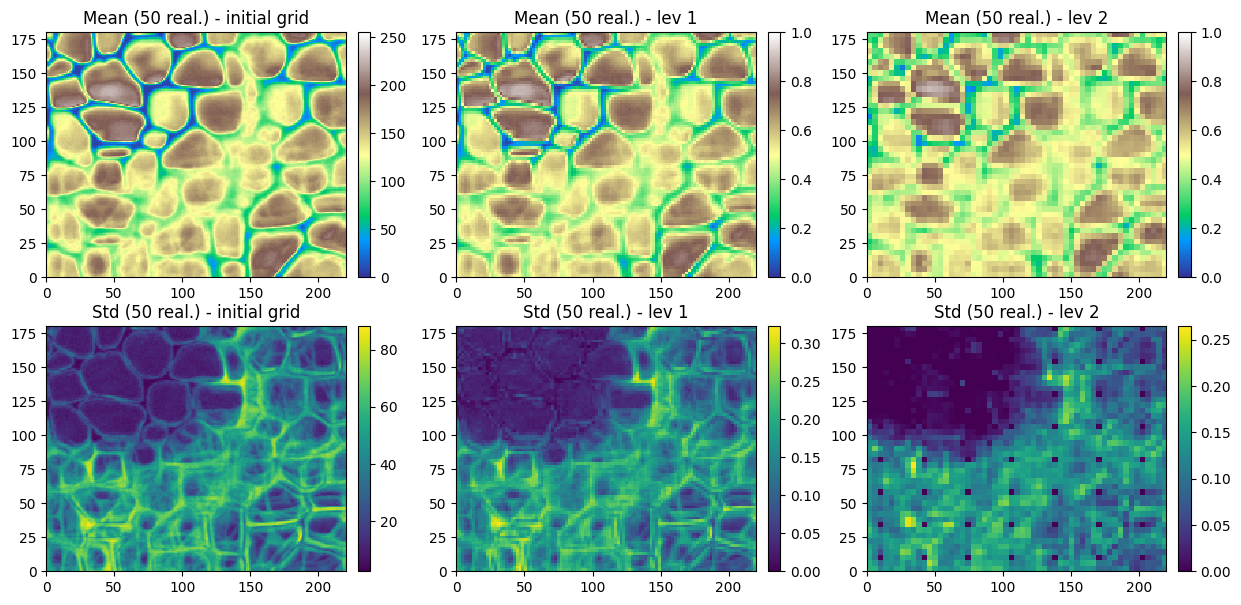

In [25]:
# Compute statistics (mean and standard deviation) over the ensemble of realizations
# ... in initial grid
all_sim_mean = gn.img.imageListContStat(sim, op='mean')
all_sim_std  = gn.img.imageListContStat(sim, op='std')

# ... in each additional pyramid level
all_sim_pyramid_mean = [gn.img.imageListContStat(sim_pyramid[j], op='mean') for j in range(nlevel)]
all_sim_pyramid_std  = [gn.img.imageListContStat(sim_pyramid[j], op='std')  for j in range(nlevel)]

# Figure
plt.subplots(2, nlevel+1, figsize=(15,2*3.5))

# Mean 
# ... in initial grid
plt.subplot(2, nlevel+1, 1)
gn.imgplot.drawImage2D(all_sim_mean, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title(f'Mean ({nreal} real.) - initial grid')

# ... in each additional pyramid level
for j in range(nlevel):
    plt.subplot(2, nlevel+1, j+2)
    gn.imgplot.drawImage2D(all_sim_pyramid_mean[j], cmap=cmap, vmin=0, vmax=1)
    plt.title(f'Mean ({nreal} real.) - lev {j+1}')

# Standard deviation
# ... in initial grid
plt.subplot(2, nlevel+1, nlevel+1+1)
gn.imgplot.drawImage2D(all_sim_std, cmap='viridis')
plt.title(f'Std ({nreal} real.) - initial grid')

# ... in each additional pyramid level
for j in range(nlevel):
    plt.subplot(2, nlevel+1, nlevel+1+j+2)
    gn.imgplot.drawImage2D(all_sim_pyramid_std[j], cmap='viridis')
    plt.title(f'Std ({nreal} real.) - lev {j+1}')

plt.show()

### 2.2 Deesse simulations with pyramids - categorical variable

Illustrations with pyramid type set to 'categorical_auto'.

#### Unconditional simulation

In [26]:
# Set-up for deesse
# -----------------
# Training image: one categorical variable
ti = gn.img.readImageTxt(os.path.join(data_dir, 'ti.txt'))

# Pyramid parameters
# ... general
pyrGenParams = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=2,                 # number of pyramid levels, additional to the simulation grid
    kx=[2, 2], ky=[2, 2], kz=[0, 0]  # reduction factors from one level to the next one
                                     #    (kz=[0, 0]: do not apply reduction along z axis)
)
# ... for the variable
pyrParams = gn.deesseinterface.PyramidParameters(
    nlevel=2,                           # number of levels
    pyramidType='categorical_auto',     # type of pyramid
    outputLevelFlag=[True, True]  # specifying for each level if the simulation is retrieved (True) 
                                  #     in output or not (False); outputLevelFlag[j] refers to level of
                                  #     index j+1
)

# number of realizations
nreal = 1

# deesse input
deesse_input = gn.deesseinterface.DeesseInput(
    nx=220, ny=180, nz=1,
    nv=1, varname='code',
    TI=ti,
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams, # set pyramid general parameters
    pyramidParameters=pyrParams,           # set pyramid parameters for each variable
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
# ----------
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 0.68 sec


In [27]:
# Retrieve the realizations 
# ... in initial grid
sim = deesse_output['sim']

# ... in (additional) pyramid levels
sim_pyramid = deesse_output['sim_pyramid']

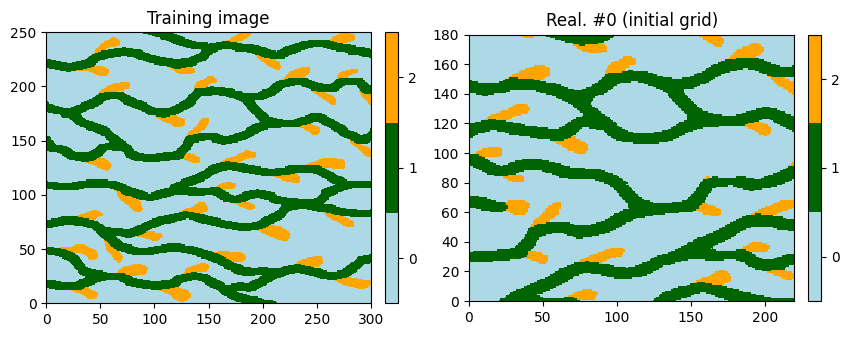

In [28]:
# Color settings
categ_val = [0, 1, 2]
categ_col = ['lightblue', 'darkgreen', 'orange']

# Display final result (in inital grid)
plt.subplots(1, 2, figsize=(10,5))

# Training image
plt.subplot(1,2,1)
gn.imgplot.drawImage2D(ti, categ=True, categVal=categ_val, categCol=categ_col)
plt.title('Training image')

# Simulation
plt.subplot(1,2,2)
gn.imgplot.drawImage2D(sim[0], categ=True, categVal=categ_val, categCol=categ_col)
plt.title(f'Real. #0 (initial grid)')

plt.show()

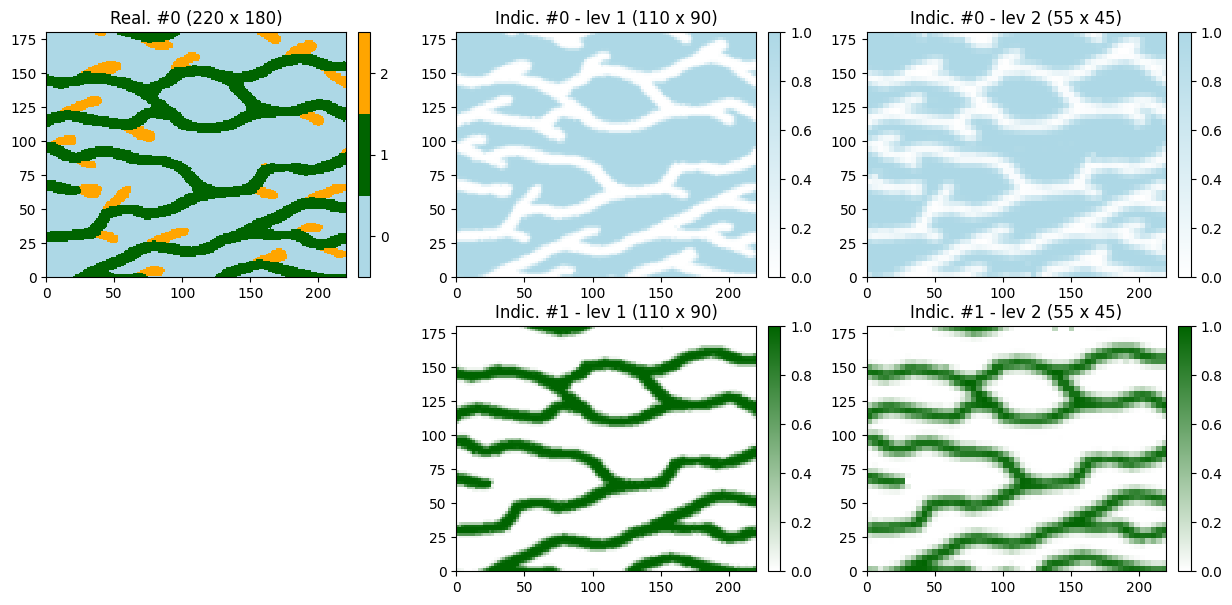

In [29]:
# Display detailed results (simulation in the pyramid)
nlevel = len(sim_pyramid)
nvar_in_level = sim_pyramid[0][0].nv

# Define color for each code and color map for each indicator
col = ['lightblue', 'darkgreen', 'orange']
cmap = [gn.customcolors.custom_cmap(['white', c]) for c in col]

plt.subplots(nvar_in_level, nlevel+1, figsize=(15,7))

# Final realization
plt.subplot(nvar_in_level, nlevel+1, 1)
gn.imgplot.drawImage2D(sim[0], categ=True, categVal=categ_val, categCol=categ_col)
plt.title(f'Real. #0 ({sim[0].nx} x {sim[0].ny})')

for k in range(nvar_in_level):
    for j in range(nlevel):
        # k-th indicator variable in level of index j+1
        plt.subplot(nvar_in_level, nlevel+1, k*(nlevel+1)+j+2)
        gn.imgplot.drawImage2D(sim_pyramid[j][0], iv=k, cmap=cmap[k], vmin=0, vmax=1)
        plt.title(f'Indic. #{k} - lev {j+1} ({sim_pyramid[j][0].nx} x {sim_pyramid[j][0].ny})')

plt.subplot(nvar_in_level, nlevel+1, (nvar_in_level-1)*(nlevel+1)+ 1)
plt.axis('off')

plt.show()

#### Setting usual conditioning data and conditioning data in the pyramid
In this example, we sample the above realization to define conditioning data in initial grid and in every additional pyramid level.

In [30]:
# Sample final simulation
hd_pts = gn.img.sampleFromImage(sim[0], size=5, seed=234)

# Sample level 1 (every variable (indicator)) (real 0)
hd_pts_lev1 = gn.img.sampleFromImage(sim_pyramid[0][0], size=6, seed=235)

# Sample level 2 (every variable (indicator)) (real 0)
hd_pts_lev2 = gn.img.sampleFromImage(sim_pyramid[1][0], size=7, seed=236)

# Set variable name (remove suffix '_real00000')
hd_pts.varname = [s.replace('_real00000', '') for s in hd_pts.varname]
hd_pts_lev1.varname = [s.replace('_real00000', '') for s in hd_pts_lev1.varname]
hd_pts_lev2.varname = [s.replace('_real00000', '') for s in hd_pts_lev2.varname]

In [31]:
hd_pts, hd_pts_lev1, hd_pts_lev2

(*** PointSet object ***
 name = 'sample_from_'
 npt = 5 # number of point(s)
 nv = 4  # number of variable(s) (including coordinates)
 varname = ['x', 'y', 'z', 'code']
 val: (4, 5)-array
 *****,
 *** PointSet object ***
 name = 'sample_from_'
 npt = 6 # number of point(s)
 nv = 5  # number of variable(s) (including coordinates)
 varname = ['x', 'y', 'z', 'code_ind000_lev001', 'code_ind001_lev001']
 val: (5, 6)-array
 *****,
 *** PointSet object ***
 name = 'sample_from_'
 npt = 7 # number of point(s)
 nv = 5  # number of variable(s) (including coordinates)
 varname = ['x', 'y', 'z', 'code_ind000_lev002', 'code_ind001_lev002']
 val: (5, 7)-array
 *****)

In [32]:
# Some stuff for plotting below...
# Color of data points
hd_pts_col = gn.imgplot.get_colors_from_values(hd_pts.val[3], 
                                               categ=True, categVal=categ_val, categCol=categ_col)

hd_pts_lev1_var0_col = gn.imgplot.get_colors_from_values(hd_pts_lev1.val[3], cmap=cmap[0], vmin=0, vmax=1)
hd_pts_lev1_var1_col = gn.imgplot.get_colors_from_values(hd_pts_lev1.val[4], cmap=cmap[1], vmin=0, vmax=1)
hd_pts_lev2_var0_col = gn.imgplot.get_colors_from_values(hd_pts_lev2.val[3], cmap=cmap[0], vmin=0, vmax=1)
hd_pts_lev2_var1_col = gn.imgplot.get_colors_from_values(hd_pts_lev2.val[4], cmap=cmap[1], vmin=0, vmax=1)

## Equivalently:
#import matplotlib.colors
#hd_pts_col = [matplotlib.colors.to_rgba(col[int(v)]) for v in hd_pts.val[3]]
#hd_pts_lev1_var0_col = [cmap[0](v) for v in hd_pts_lev1.val[3]]
#hd_pts_lev1_var1_col = [cmap[1](v) for v in hd_pts_lev1.val[4]]
#hd_pts_lev2_var0_col = [cmap[0](v) for v in hd_pts_lev2.val[3]]
#hd_pts_lev2_var1_col = [cmap[1](v) for v in hd_pts_lev2.val[4]]

hd_col_in_pyr = [[hd_pts_lev1_var0_col, hd_pts_lev1_var1_col], # in lev. 1
                 [hd_pts_lev2_var0_col, hd_pts_lev2_var1_col]] # in lev. 2

# Coordinates of data points in pyramid levels
hd_x_in_pyr = [hd_pts_lev1.x(), hd_pts_lev2.x()]
hd_y_in_pyr = [hd_pts_lev1.y(), hd_pts_lev2.y()]

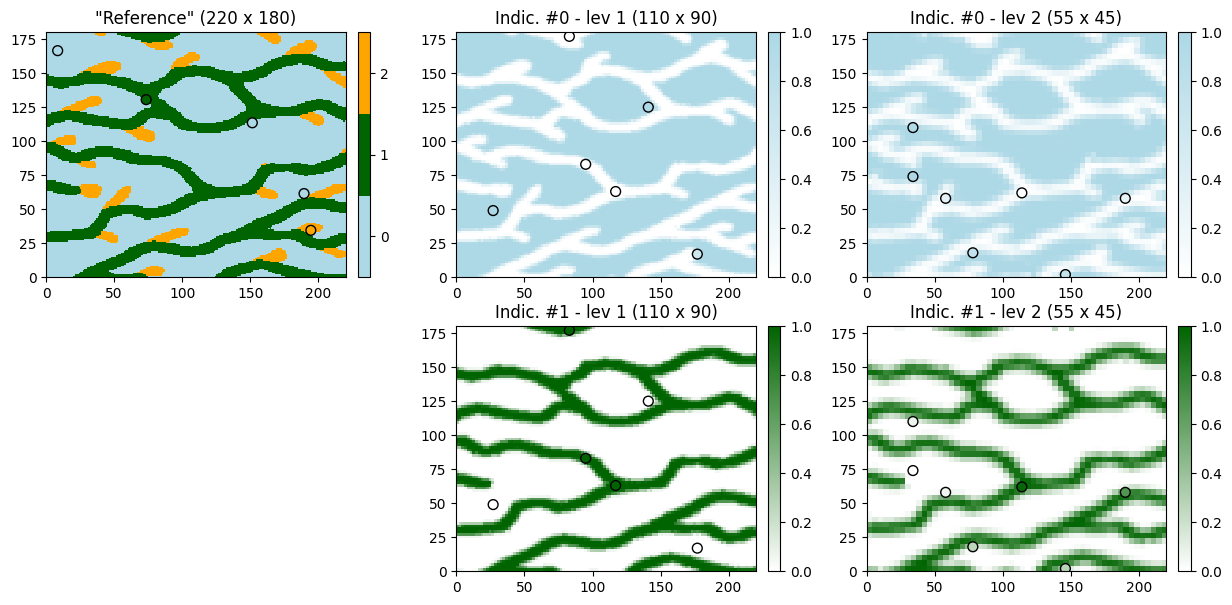

In [33]:
# Plot conditioning data and reference (realization from which the data are sampled)

plt.subplots(nvar_in_level, nlevel+1, figsize=(15,7))

# Final grid
plt.subplot(nvar_in_level, nlevel+1, 1)
gn.imgplot.drawImage2D(sim[0], categ=True, categVal=categ_val, categCol=categ_col)
plt.scatter(hd_pts.x(), hd_pts.y(), marker='o', s=50, 
            color=hd_pts_col, edgecolors='black', linewidths=1) # add data points
plt.title(f'"Reference" ({sim[0].nx} x {sim[0].ny})')

for k in range(nvar_in_level):
    for j in range(nlevel):
        # k-th indicator variable in level of index j+1
        plt.subplot(nvar_in_level, nlevel+1, k*(nlevel+1)+j+2)
        gn.imgplot.drawImage2D(sim_pyramid[j][0], iv=k, cmap=cmap[k], vmin=0, vmax=1)
        plt.scatter(hd_x_in_pyr[j], hd_y_in_pyr[j], marker='o', s=50, 
                    #color='red', edgecolors='black', linewidths=1) # add data points
                    color=hd_col_in_pyr[j][k], edgecolors='black', linewidths=1) # add data points
        plt.title(f'Indic. #{k} - lev {j+1} ({sim_pyramid[j][0].nx} x {sim_pyramid[j][0].ny})')

plt.subplot(nvar_in_level, nlevel+1, (nvar_in_level-1)*(nlevel+1)+ 1)
plt.axis('off')

plt.show()

In [34]:
# Set-up for deesse
# -----------------
# number of realizations
nreal = 50

# deesse input
deesse_input = gn.deesseinterface.DeesseInput(
    nx=220, ny=180, nz=1,
    nv=1, varname='code',
    TI=ti,
    dataPointSet=hd_pts,                   # set usual data point set
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams, # same parameters as above
    pyramidParameters=pyrParams,           # same parameters as above (outputLevelFlag could be changed)
    pyramidDataPointSet=[hd_pts_lev1,hd_pts_lev2],  # set data point sets for pyramid
    #conditioningWeightFactor=10.,  # put more weight to conditioning data (usual data and in pyr.) (if needed)
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
# ----------
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun_mp(deesse_input, nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun_mp: DeeSse running on 4 process(es)... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
deesseRun_mp: DeeSse run complete (all process(es))
Elapsed time: 28 sec


In [35]:
# Retrieve the realizations 
# ... in initial grid
sim = deesse_output['sim']

# ... in (additional) pyramid levels
sim_pyramid = deesse_output['sim_pyramid']

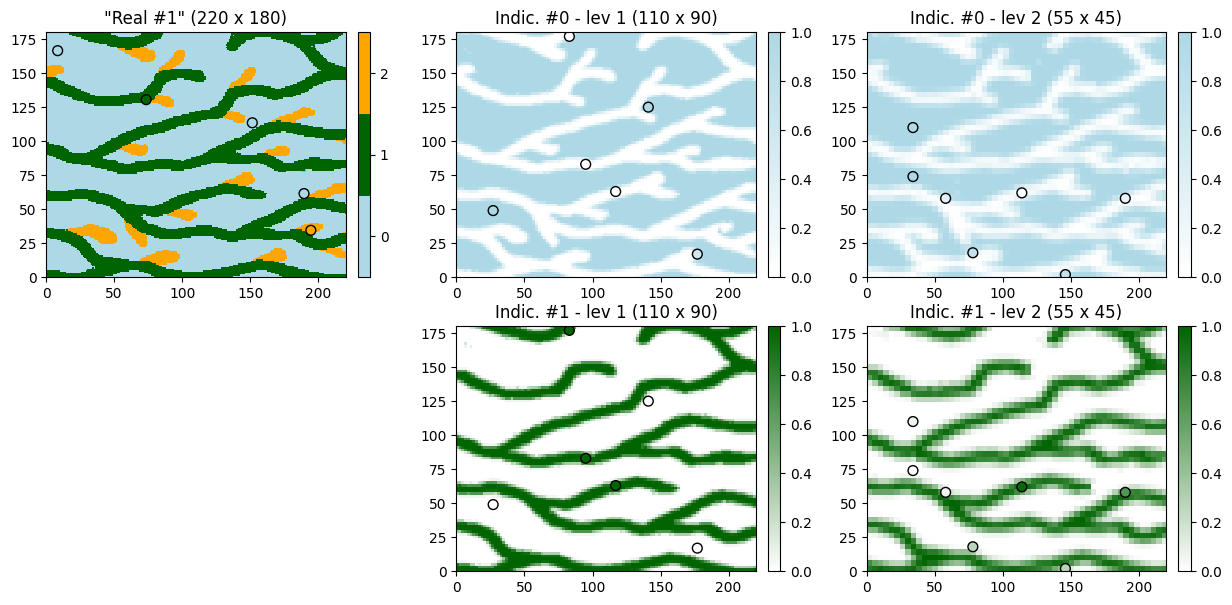

In [36]:
# Display detailed results (simulation in the pyramid), one realization
i = 1 # realization index

plt.subplots(nvar_in_level, nlevel+1, figsize=(15,7))

# Final grid
plt.subplot(nvar_in_level, nlevel+1, 1)
gn.imgplot.drawImage2D(sim[i], categ=True, categVal=categ_val, categCol=categ_col)
plt.scatter(hd_pts.x(), hd_pts.y(), marker='o', s=50, 
            color=hd_pts_col, edgecolors='black', linewidths=1) # add data points
plt.title(f'"Real #{i}" ({sim[i].nx} x {sim[i].ny})')

for k in range(nvar_in_level):
    for j in range(nlevel):
        # k-th indicator variable in level of index j+1
        plt.subplot(nvar_in_level, nlevel+1, k*(nlevel+1)+j+2)
        gn.imgplot.drawImage2D(sim_pyramid[j][i], iv=k, cmap=cmap[k], vmin=0, vmax=1)
        plt.scatter(hd_x_in_pyr[j], hd_y_in_pyr[j], marker='o', s=50, 
                    color=hd_col_in_pyr[j][k], edgecolors='black', linewidths=1) # add data points
        plt.title(f'Indic. #{k} - lev {j+1} ({sim_pyramid[j][i].nx} x {sim_pyramid[j][i].ny})')

plt.subplot(nvar_in_level, nlevel+1, (nvar_in_level-1)*(nlevel+1)+ 1)
plt.axis('off')

plt.show()

#### Do some statistics over the ensemble of realizations

In [37]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)
# EQUIVALENT TO NEXT CELL

# Gather the realizations into one image
# ... in initial grid
all_sim = gn.img.gatherImages(sim)

# ... in each additional pyramid level
all_sim_pyramid_var0 = [gn.img.gatherImages(sim_pyramid[j], varInd=0) for j in range(nlevel)]
all_sim_pyramid_var1 = [gn.img.gatherImages(sim_pyramid[j], varInd=1) for j in range(nlevel)]

# Compute statistics over the ensemble of realizations
# ... in initial grid: proportion of each category
all_sim_stats = gn.img.imageCategProp(all_sim, [0, 1, 2])

# ... in each additional pyramid level: mean and standard deviation
all_sim_pyramid_var0_mean = [gn.img.imageContStat(all_sim_pyramid_var0[j], op='mean') for j in range(nlevel)]
all_sim_pyramid_var0_std  = [gn.img.imageContStat(all_sim_pyramid_var0[j], op='std')  for j in range(nlevel)]
all_sim_pyramid_var1_mean = [gn.img.imageContStat(all_sim_pyramid_var1[j], op='mean') for j in range(nlevel)]
all_sim_pyramid_var1_std  = [gn.img.imageContStat(all_sim_pyramid_var1[j], op='std')  for j in range(nlevel)]

In [38]:
# Compute statistics over the ensemble of realizations
# ... in initial grid: proportion of each category
all_sim_stats = gn.img.imageListCategProp(sim, [0, 1, 2])

# ... in each additional pyramid level: mean and standard deviation
all_sim_pyramid_var0_mean = [gn.img.imageListContStat(sim_pyramid[j], op='mean', ind=0) for j in range(nlevel)]
all_sim_pyramid_var0_std  = [gn.img.imageListContStat(sim_pyramid[j], op='std' , ind=0) for j in range(nlevel)]
all_sim_pyramid_var1_mean = [gn.img.imageListContStat(sim_pyramid[j], op='mean', ind=1) for j in range(nlevel)]
all_sim_pyramid_var1_std  = [gn.img.imageListContStat(sim_pyramid[j], op='std' , ind=1) for j in range(nlevel)]

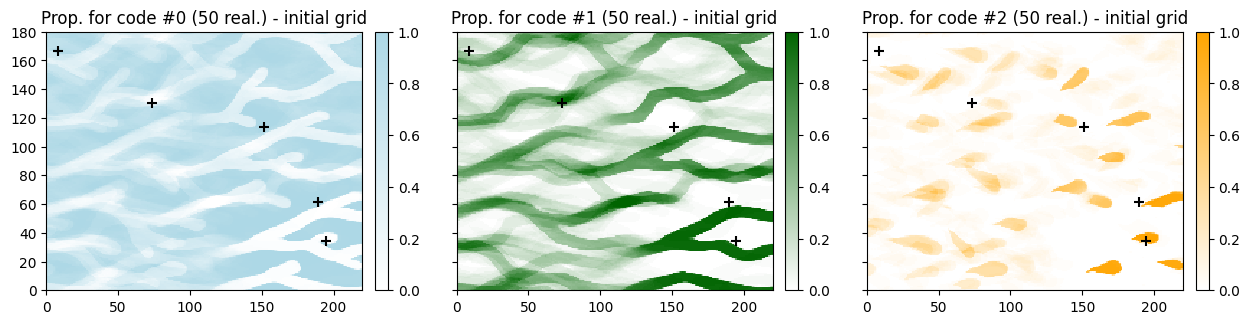

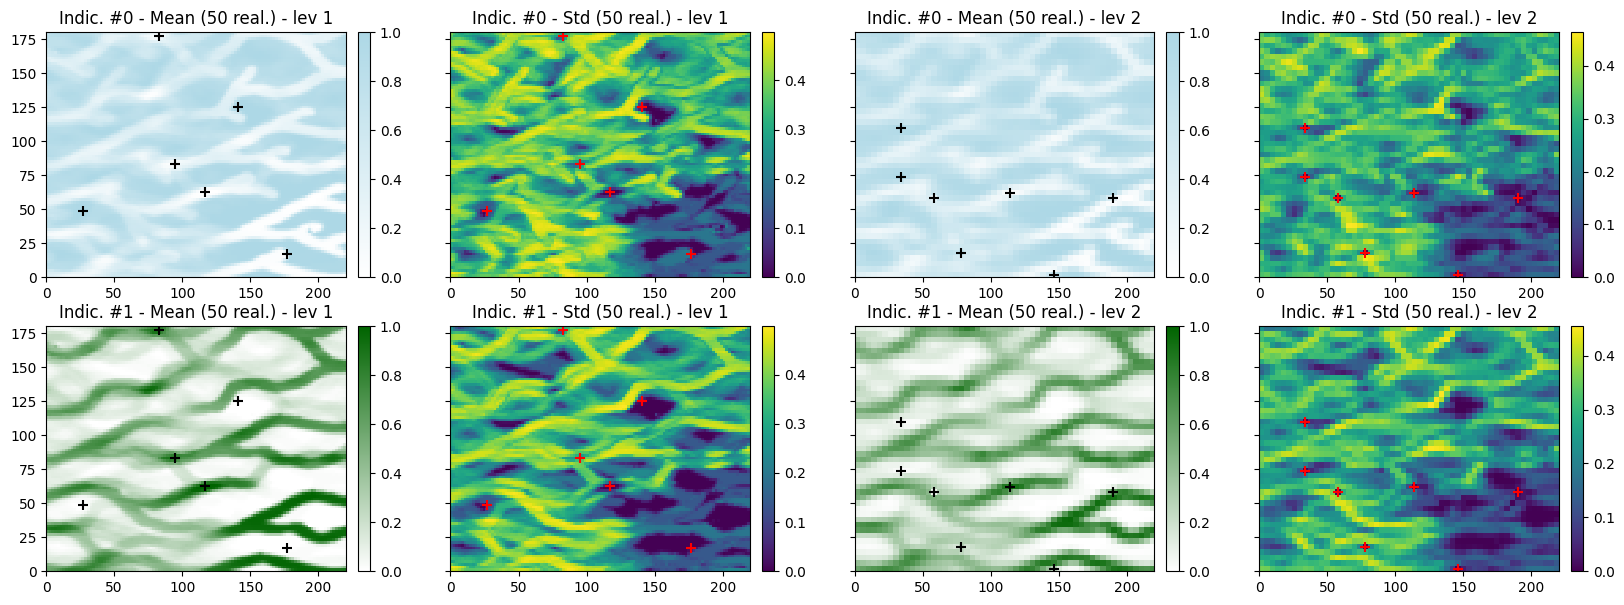

In [39]:
# Number of categories
ncateg = 3

# Figure - statistics in initial grid
plt.subplots(1, ncateg, figsize=(ncateg*5,3.5), sharey=True)
for k in range(ncateg):
    plt.subplot(1, ncateg, k+1)
    gn.imgplot.drawImage2D(all_sim_stats, iv=k, cmap=cmap[k], vmin=0, vmax=1)
    plt.scatter(hd_pts.x(), hd_pts.y(), marker='+', s=50, color='black') # add data points location
    plt.title(f'Prop. for code #{k} ({nreal} real.) - initial grid')


# Figure - mean and standard deviation of indicators in additional pyramid levels
nrow = ncateg-1
ncol = 2*nlevel
plt.subplots(nrow, ncol, figsize=(ncol*5,nrow*3.5), sharey=True)

# indicator k=0
k = 0
for j in range(nlevel):
    plt.subplot(nrow, ncol, k*ncol+2*j+1)
    gn.imgplot.drawImage2D(all_sim_pyramid_var0_mean[j], cmap=cmap[k], vmin=0, vmax=1)
    plt.scatter(hd_x_in_pyr[j], hd_y_in_pyr[j], marker='+', s=50, color='black') # add data points location
    plt.title(f'Indic. #{k} - Mean ({nreal} real.) - lev {j+1}')
    
    plt.subplot(nrow, ncol, k*ncol+2*j+2)
    gn.imgplot.drawImage2D(all_sim_pyramid_var0_std[j], cmap='viridis')
    plt.scatter(hd_x_in_pyr[j], hd_y_in_pyr[j], marker='+', s=50, color='red') # add data points location
    plt.title(f'Indic. #{k} - Std ({nreal} real.) - lev {j+1}')

# indicator k=1
k = 1
for j in range(nlevel):
    plt.subplot(nrow, ncol, k*ncol+2*j+1)
    gn.imgplot.drawImage2D(all_sim_pyramid_var1_mean[j], cmap=cmap[k], vmin=0, vmax=1)
    plt.scatter(hd_x_in_pyr[j], hd_y_in_pyr[j], marker='+', s=50, color='black') # add data points location
    plt.title(f'Indic. #{k} - Mean ({nreal} real.) - lev {j+1}')
    
    plt.subplot(nrow, ncol, k*ncol+2*j+2)
    gn.imgplot.drawImage2D(all_sim_pyramid_var1_std[j], cmap='viridis')
    plt.scatter(hd_x_in_pyr[j], hd_y_in_pyr[j], marker='+', s=50, color='red') # add data points location
    plt.title(f'Indic. #{k} - Std ({nreal} real.) - lev {j+1}')

plt.show()